![cg.jpg](https://raw.githubusercontent.com/jdanifalcon/FundamentosIA/main/logo/logo_cg.jpg)


# Tarea 5: "Regresión robusta con base de Fourier y RANSAC".

#### Aprendizaje de máquina
#### @date 11/06/2023
#### @autor: Jessica Daniela Ocaña Falcón
#### sede: Mérida, Yucatan
#### Orientación: Geointeligencia Computacional

##Introducción

En esta tarea, explorarás la aplicación de series de Fourier en el análisis de regresión, particularmente para manejar datos con características periódicas o límites conocidos. Implementarás la regresión utilizando una serie de Fourier truncada como función base y aplicarás el algoritmo RANSAC para estimar robustamente los parámetros del modelo en presencia de valores atípicos.

###Serie de Fourier como Función Base

La serie de Fourier es una herramienta poderosa para modelar funciones periódicas. Para los propósitos de esta tarea, utilizarás un conjunto de funciones de coseno y seno como funciones base, definidas de la siguiente manera:

$\phi_0(x) = 1$

$\phi_j(x) =
\begin{cases}
\cos(\pi x j) & \text{si } j \text{ es impar} \\
\sin(\pi x j) & \text{si } j \text{ es par}
\end{cases}$

donde $j > 0$. Esta serie se truncará a un número razonable de términos, que determinarás en función del conjunto de datos proporcionado.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
# Definir la función base phi_j(x) para la serie de Fourier
def phi_j(x, j):
    """Función base de Fourier.

    Parámetros:
    x -- Array de valores de entrada.
    j -- Índice del término de Fourier.

    Retorna:
    Valores de la base de Fourier correspondientes a x y j.
    """
    if j == 0:
        return np.ones_like(x)
    elif j % 2 == 1:  # j impar
        return np.cos(np.pi * j * x)
    else:  # j par
        return np.sin(np.pi * j * x)

# Construir la matriz de diseño usando términos de Fourier
def design_matrix(x, max_j):
    """Construir la matriz de diseño para la serie de Fourier.

    Parámetros:
    x -- Array de valores de entrada.
    max_j -- Número máximo de términos de Fourier.

    Retorna:
    Matriz de diseño X.
    """
    X = np.column_stack([phi_j(x, j) for j in range(max_j + 1)])
    return X

# Función para ajustar el modelo usando mínimos cuadrados
def fit_model(X, y):
    """Ajustar a un modelo de mínimos cuadrados.

    Parámetros:
    X -- Matriz de diseño.
    y -- Valores objetivo.

    Retorna:
    Coeficientes del modelo ajustado.
    """
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy = X.T @ y
    theta = XTX_inv @ XTy
    return theta

# Función para predecir usando el modelo ajustado
def predict_model(X, theta):
    """Realizar predicciones usando el modelo ajustado.

    Parámetros:
    X -- Matriz de diseño.
    theta -- Coeficientes del modelo.

    Retorna:
    Predicciones del modelo.
    """
    return X @ theta


In [9]:
# Algoritmo RANSAC para ajustar el modelo robusto a los datos con outliers
def ransac(x, y, max_j, K, n, T):
    """Ejecutar el algoritmo RANSAC para ajustar un modelo robusto.

    Parámetros:
    x -- Array de valores de entrada.
    y -- Valores objetivo con ruido y outliers.
    max_j -- Número máximo de términos de Fourier.
    K -- Número de iteraciones.
    n -- Número de puntos de muestra en cada iteración.
    T -- Umbral para determinar inliers.

    Retorna:
    Coeficientes del mejor modelo ajustado por RANSAC.
    """
    best_theta = None
    max_inliers = 0

    for k in range(K):
        # Seleccionar aleatoriamente n puntos
        indices = np.random.choice(len(x), n, replace=True)
        X_sample = design_matrix(x[indices], max_j)
        y_sample = y[indices]

        # Ajustar el modelo a estos puntos
        theta = fit_model(X_sample, y_sample)

        # Contar el número de inliers
        inlier_count = 0
        X_full = design_matrix(x, max_j)
        y_pred = predict_model(X_full, theta)
        residuals = np.abs(y - y_pred)

        for i in range(len(y)):
            if residuals[i] < T:
                inlier_count += 1

        # Actualizar el mejor modelo si es necesario
        if inlier_count > max_inliers:
            max_inliers = inlier_count
            best_theta = theta

    return best_theta

# Generar datos sintéticos con características periódicas
np.random.seed(0)
x = np.linspace(0, 1, 100)
y_true = 2 * np.sin(4 * np.pi * x) + 0.5 * np.cos(8 * np.pi * x)

# Introducir ruido
y_noisy = y_true + np.random.normal(0, 0.5, len(x))

# Introducir valores atípicos (outliers)
n_outliers = 50
outlier_indices = np.random.choice(len(x), n_outliers, replace=True)
y_noisy[outlier_indices] += np.random.normal(0, 2, n_outliers)

# Parámetros del algoritmo RANSAC
K = 1000  # Número de iteraciones
n = 49    # Número de puntos de muestra en cada iteración
T = 0.5   # Umbral de inliers
max_j = 4 # Número de términos de Fourier

# Ejecutar RANSAC
best_theta_ransac = ransac(x, y_noisy, max_j, K, n, T)

# Ajustar el modelo usando mínimos cuadrados ordinarios (OLS)
X_full = design_matrix(x, max_j)
theta_ols = fit_model(X_full, y_noisy)

# Predecir usando ambos modelos
y_ransac_pred = predict_model(X_full, best_theta_ransac)
y_ols_pred = predict_model(X_full, theta_ols)

# Calcular MSE y RMSE
mse_ransac = mean_squared_error(y_true, y_ransac_pred)
rmse_ransac = np.sqrt(mse_ransac)
mse_ols = mean_squared_error(y_true, y_ols_pred)
rmse_ols = np.sqrt(mse_ols)

# Imprimir los resultados
print(f'RANSAC MSE: {mse_ransac}, RMSE: {rmse_ransac}')
print(f'OLS MSE: {mse_ols}, RMSE: {rmse_ols}')

RANSAC MSE: 0.219851115664258, RMSE: 0.46888283788624424
OLS MSE: 0.20846175135342063, RMSE: 0.45657611780887164


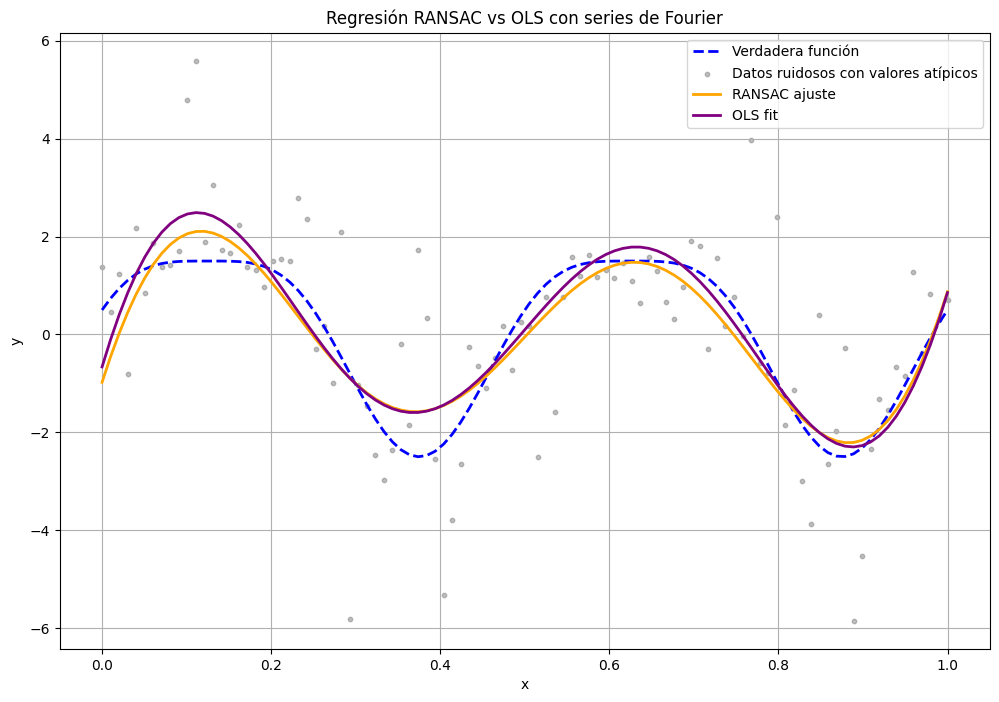

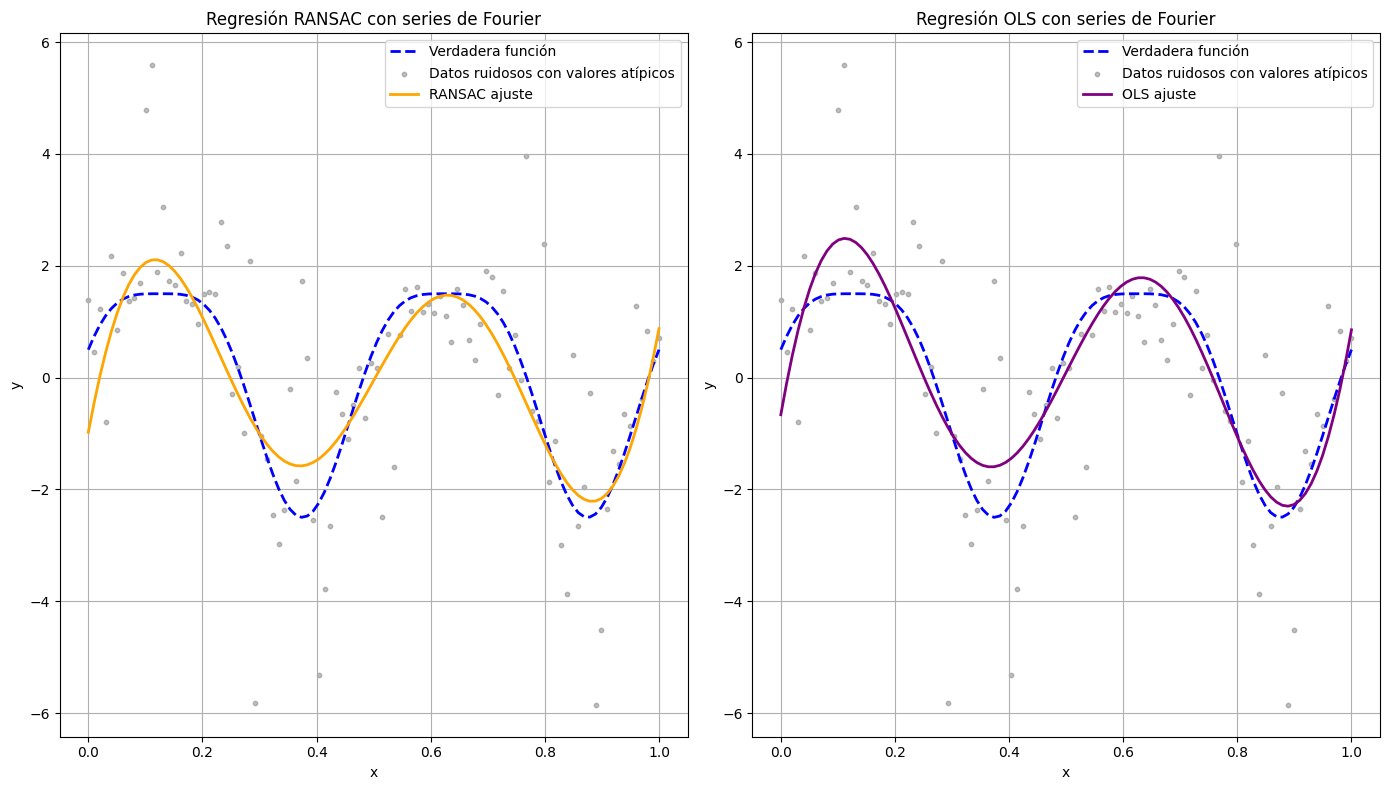

In [10]:
# Visualizar los resultados de RANSAC y OLS en una sola gráfica
plt.figure(figsize=(12, 8))
plt.plot(x, y_true, label='Verdadera función', linestyle='--', linewidth=2, color='blue')
plt.scatter(x, y_noisy, color='gray', label='Datos ruidosos con valores atípicos', alpha=0.5, s=10)
plt.plot(x, y_ransac_pred, label='RANSAC ajuste', color='orange', linewidth=2)
plt.plot(x, y_ols_pred, label='OLS fit', color='purple', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regresión RANSAC vs OLS con series de Fourier')
plt.grid(True)
plt.show()

# Generar la figura comparativa con subplots
plt.figure(figsize=(14, 8))

# Subplot para RANSAC
plt.subplot(1, 2, 1)
plt.plot(x, y_true, label='Verdadera función', linestyle='--', linewidth=2, color='blue')
plt.scatter(x, y_noisy, color='gray', label='Datos ruidosos con valores atípicos', alpha=0.5, s=10)
plt.plot(x, y_ransac_pred, label='RANSAC ajuste', color='orange', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regresión RANSAC con series de Fourier')
plt.grid(True)

# Subplot para OLS
plt.subplot(1, 2, 2)
plt.plot(x, y_true, label='Verdadera función', linestyle='--', linewidth=2, color='blue')
plt.scatter(x, y_noisy, color='gray', label='Datos ruidosos con valores atípicos', alpha=0.5, s=10)
plt.plot(x, y_ols_pred, label='OLS ajuste', color='purple', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regresión OLS con series de Fourier')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Análisis del rendimiento del modelo en función del número de términos de Fourier
max_terms = 20
errors = []

for max_j in range(1, max_terms + 1):
    X = design_matrix(x, max_j)
    model = LinearRegression()
    model.fit(X, y_noisy)
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    errors.append(mse)

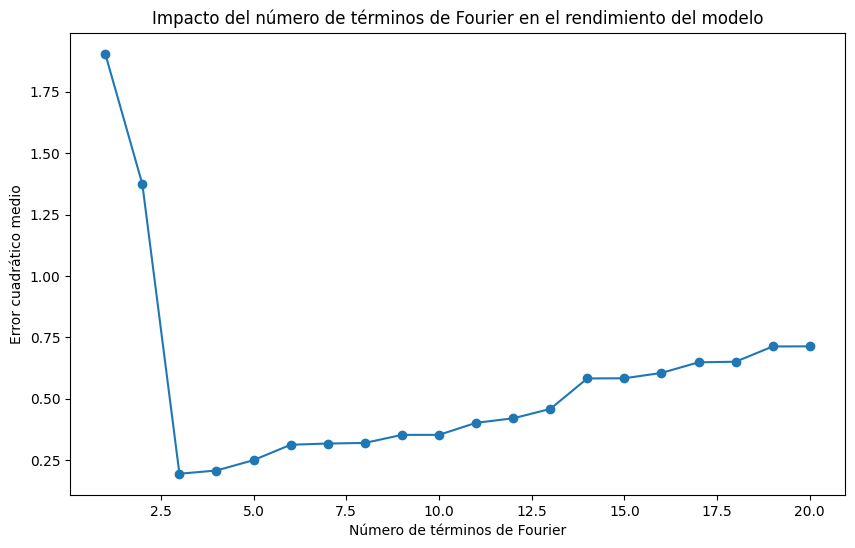

In [12]:
# Visualizar el error en función del número de términos de Fourier
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_terms + 1), errors, marker='o')
plt.xlabel('Número de términos de Fourier')
plt.ylabel('Error cuadrático medio')
plt.title('Impacto del número de términos de Fourier en el rendimiento del modelo')
plt.show()

In [8]:
# Seleccionar un número apropiado de términos basado en el análisis
optimal_terms = np.argmin(errors) + 1
print(f'Número óptimo de términos de Fourier: {optimal_terms}')

Número óptimo de términos de Fourier: 3
